# Subgraph/clustering analysis of Nanog overexpression tf/ppi graph

## Analysis:

1. Hierarchical clustering
2. Identify clusters with NANOG
3. Identify breakpoint to separate NANOG cluster
    - Figure out ratio of inside edges to outside edges of each cluster
    - Figure out size of each cluster (edges, vertices)
4. Separate NANOG cluster at appropriate level
5. Re-cluster with ordering
6. Identify top/bottom of hierarchy
7. Figure out biology of ranking
    - Go analysis at each level of hierarchy

In [1]:
import pickle
import networkx as nx
from graph_tool.all import *
import numpy as np
import graph_tool as gt
from nx2gt import nx2gt

In [2]:
# Set the random seed for reproducibility
import numpy as np
np.random.seed(42)
# Set the seed in graphtool
gt.seed_rng(42)
# Set the seed in python
import random
random.seed(42)

In [3]:
graph = pickle.load(open('../data/filtered_graph.pickle','rb'))

In [4]:
# Convert to graphtool graph from networkx
graph = nx2gt(graph)

In [5]:
graph.num_edges()

878

In [6]:
graph.num_vertices()

271

In [7]:
gene_id_to_name = pickle.load(open('../data/gene_id_to_name.pickle','rb'))
protein_id_to_name = pickle.load(open('../data/protein_id_to_name.pickle','rb'))

In [8]:
# Add gene name as a vertex property
graph.vertex_properties['name'] = graph.new_vertex_property('string')
for gene_index in graph.vertices():
    gene_id = graph.vertex_properties['id'][gene_index]
    gene_name = '/'.join(protein_id_to_name.get(gene_id, None))
    # Add the gene name as a vertex property
    graph.vertex_properties['name'][gene_index] = gene_name

### Hierarchical Clustering

In [9]:
def refine(state, n=1000):
    s1 = state.entropy()
    for i in range(n): # this should be sufficiently large
        state.multiflip_mcmc_sweep(beta=np.inf, niter=10)

    s2 = state.entropy()
    return state, s1, s2

In [10]:
hierarchical = gt.inference.minimize_nested_blockmodel_dl(graph)

In [11]:
r_state_dc, s1, s2 = refine(hierarchical)
print(s1, s2, s1-s2)

4255.608912767168 4180.924417810992 74.68449495617551


In [12]:
r_state_dc, s1, s2 = refine(hierarchical, 10)
print(s1, s2, s1-s2)

4180.924417810992 4180.924417810992 0.0


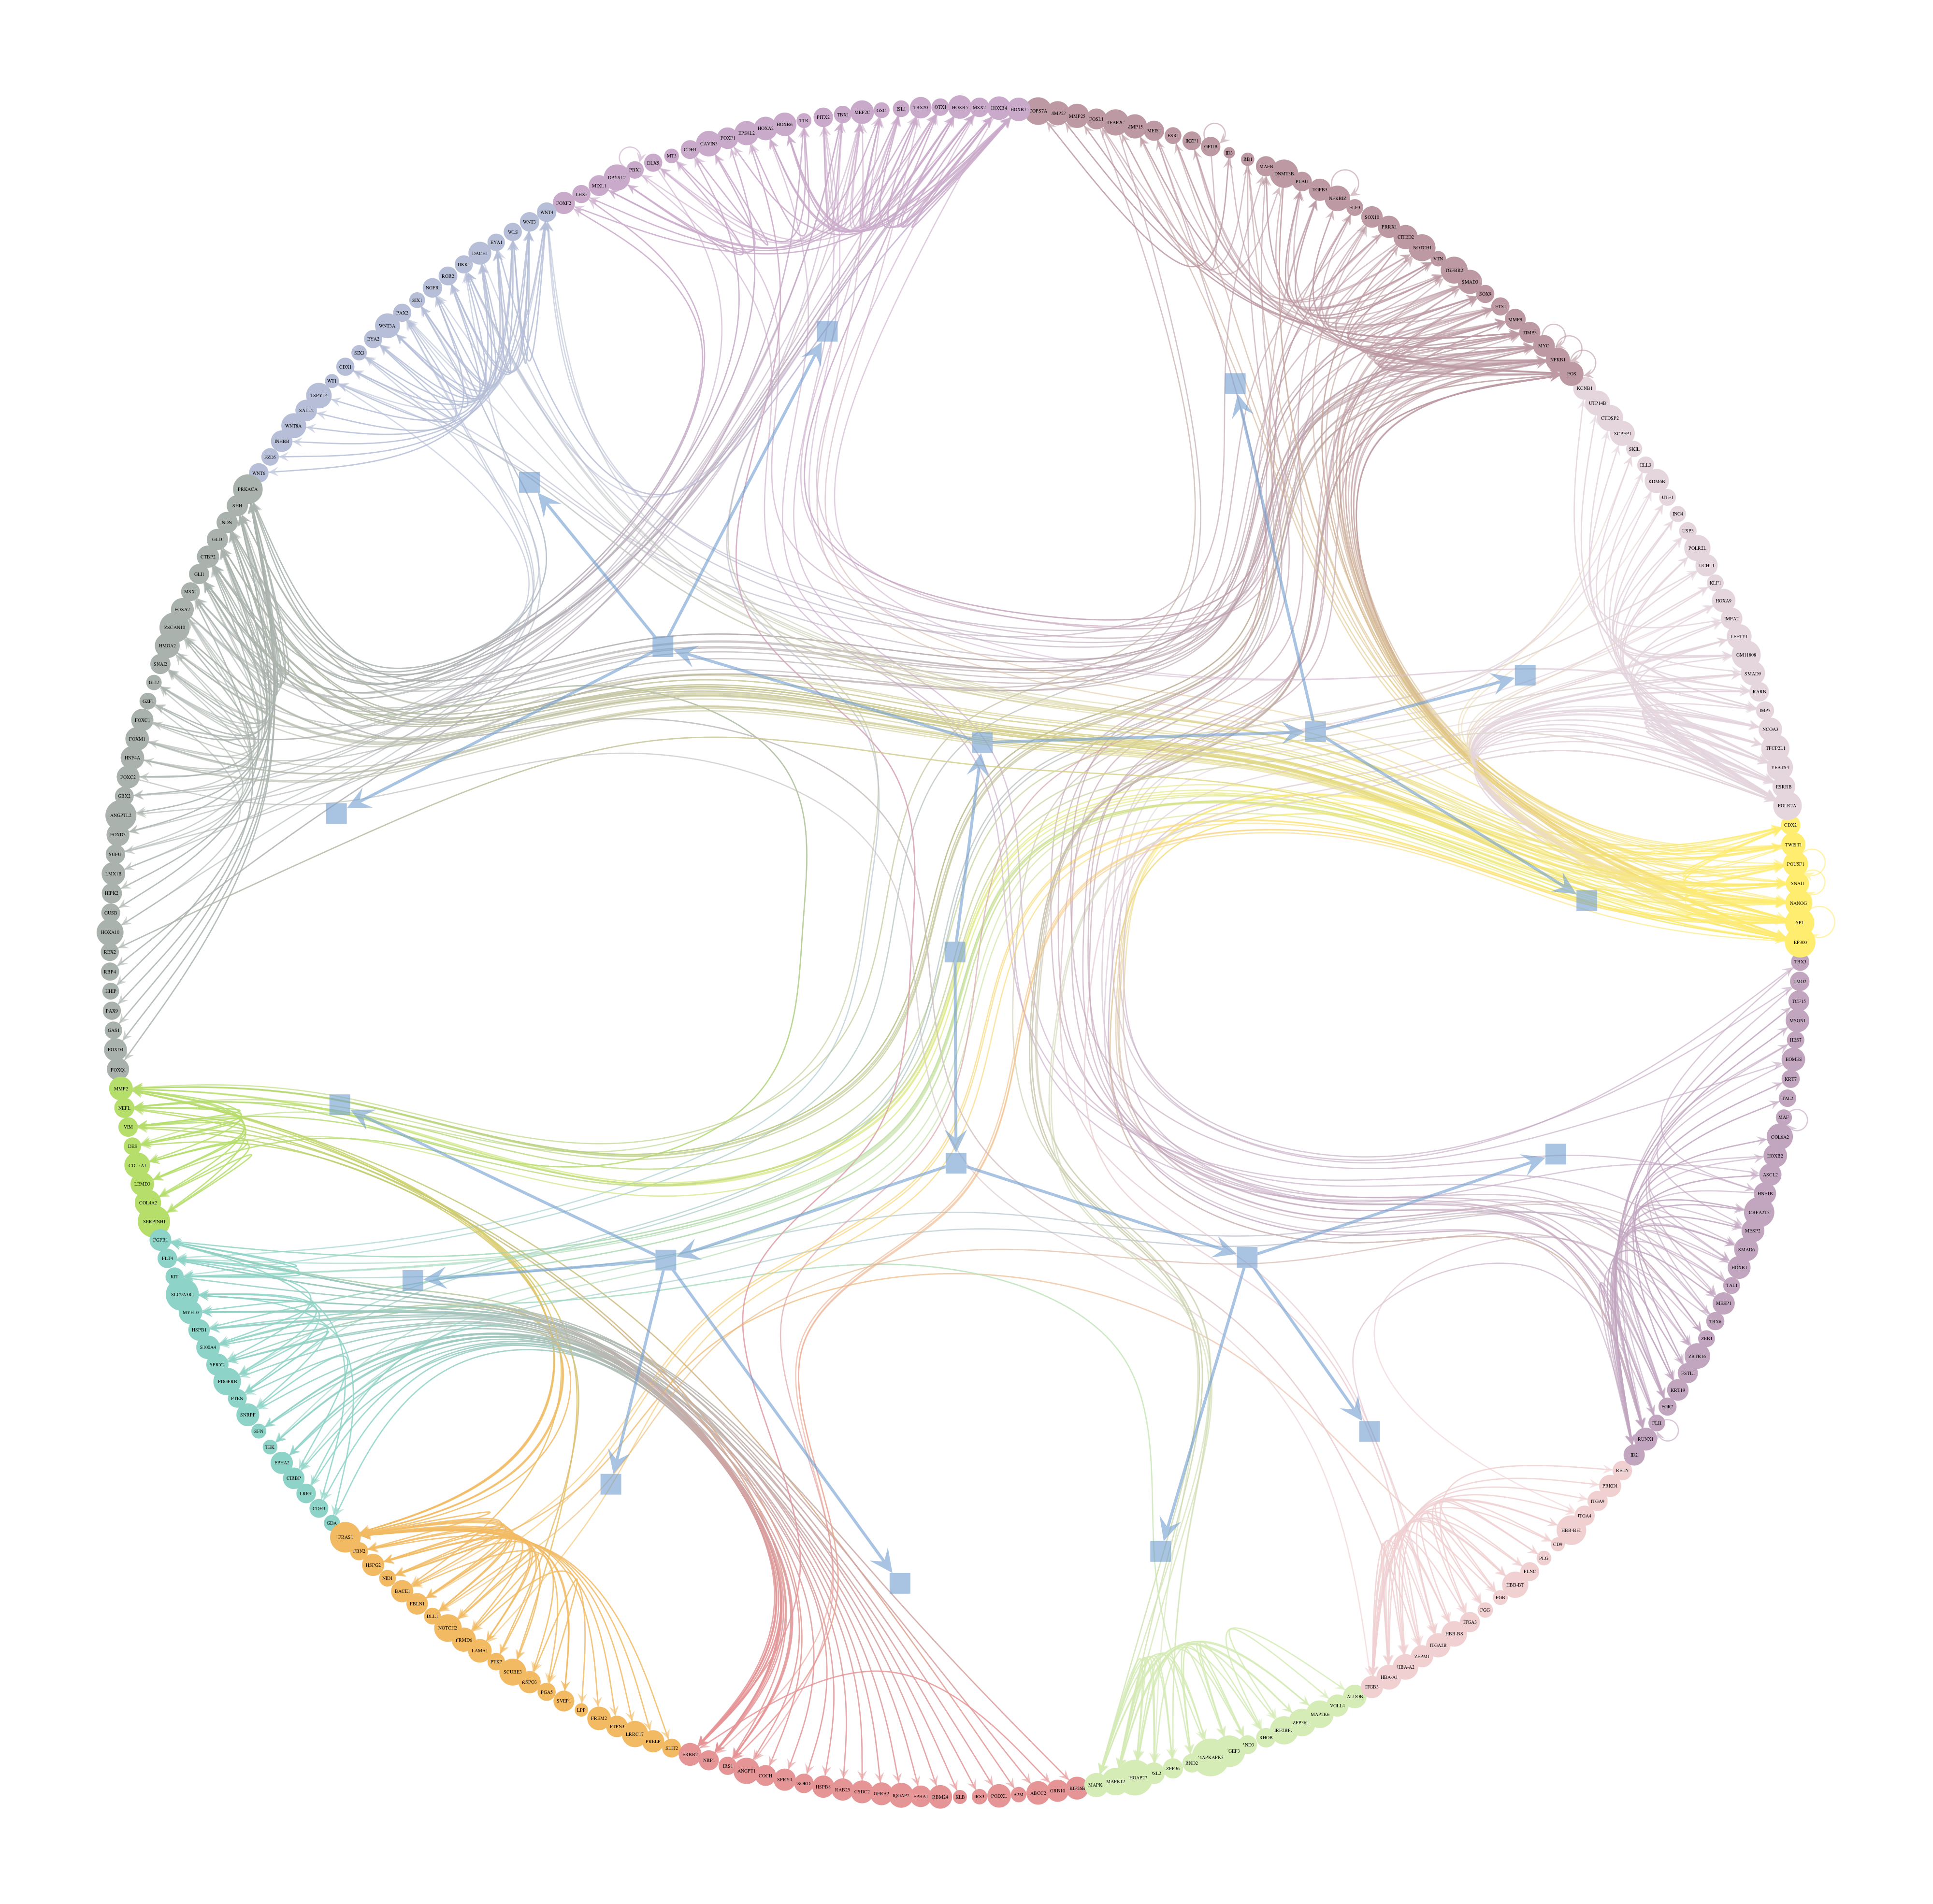

In [13]:

hierarchical.draw(vertex_text=graph.vertex_properties['name'],
                    vertex_font_size=5,
                    # expand the size of the plot
                    output_size=(2000, 2000)
                    );

In [14]:
levels = [level for level in hierarchical.levels if level.get_nonempty_B() > 1]

n_vertices = hierarchical.g.num_vertices()
n_levels = len(levels)
vertex_blocks = np.zeros((n_vertices, n_levels), dtype=int)

blocks = hierarchical.levels[0].get_blocks()

for i,block in enumerate(blocks):
    vertex_blocks[i, 0] = block

for i in range(1, n_levels):
    current_blocks = hierarchical.levels[i].get_blocks()
#     print(len(list(current_blocks)))
    for j,last_block in enumerate(vertex_blocks[:,i-1]):
        block = current_blocks[last_block]
        vertex_blocks[j,i] = block

In [15]:
for i in range(10):
    for j in range(len(levels)):
        print(f'{vertex_blocks[i,j]:4d}',end=',')
    print()

  41,   3,   1,
  61,   1,   0,
  61,   1,   0,
 129,   3,   1,
 246,   5,   0,
  26,   1,   0,
 246,   5,   0,
  61,   1,   0,
  44,   3,   1,
  26,   1,   0,


## Identify clusters with NANOG

In [16]:
protein_id_to_name = pickle.load(open('../data/protein_id_to_name.pickle','rb'))
gene_id_to_name = pickle.load(open('../data/gene_id_to_name.pickle','rb'))

names_to_protein_ids = pickle.load(open('../data/protein_names.pickle','rb'))
names_to_gene_ids = pickle.load(open('../data/gene_names.pickle','rb'))

In [17]:
nanog_ids = names_to_gene_ids['NANOG'] | names_to_protein_ids['NANOG']
nanog_ids

{'ENSMUSG00000012396',
 'ENSMUSP00000012540',
 'ENSMUSP00000108199',
 'ENSMUSP00000108200'}

In [18]:
nanog_vertices = []
for i,vertex in enumerate(graph.vertices()):
#     print(i, vertex)
    for nanog_id in nanog_ids:
        vertex_name = graph.vertex_properties['id'][vertex]
        if vertex_name == nanog_id:
#             assert i==vertex, f'{i}, {vertex}'
            print(i,vertex, vertex_name, vertex_blocks[i])
            nanog_vertices.append(i)

261 261 ENSMUSP00000012540 [40  5  0]


## Ranked Block Model

In [19]:
ranked = NestedBlockState(graph, base_type=RankedBlockState)
for i in range(100):
    ranked.multiflip_mcmc_sweep(beta=np.inf, niter=10)

In [20]:
r_state_dc, s1, s2 = refine(ranked)
print(s1, s2, s1-s2)

4191.019596844131 4187.012720754686 4.006876089445541


In [52]:
r_state_dc, s1, s2 = refine(ranked, 200)
print(s1, s2, s1-s2)

4169.5221743651055 4169.5221743651055 0.0


In [53]:
vertex_ranks = []
i=0
for x in r_state_dc.levels[0].get_vertex_order():
    vertex_ranks.append((x,i))
    i+=1
for rank, vertex_num in sorted(vertex_ranks):
    vertex_id = graph.vertex_properties['id'][vertex_num]
    protein_name = protein_id_to_name.get(vertex_id, None)
    print(f'{rank:4d} {vertex_id} {"/".join(protein_name)}')

   0 ENSMUSP00000036580 WNT4
   0 ENSMUSP00000025521 CDX1
   0 ENSMUSP00000090287 RSPO3
   0 ENSMUSP00000038366 SCUBE3
   0 ENSMUSP00000026917 NRP1
   0 ENSMUSP00000113103 LEMD3
   0 ENSMUSP00000027409 DES
   0 ENSMUSP00000022639 NEFL
   0 ENSMUSP00000025647 PGA5
   0 ENSMUSP00000099375 ITGA2B
   0 ENSMUSP00000031131 UCHL1
   0 ENSMUSP00000025522 PDGFRB
   0 ENSMUSP00000010044 WNT3A
   0 ENSMUSP00000005815 KIT
   0 ENSMUSP00000028062 VIM
   0 ENSMUSP00000064163 FLNC
   0 ENSMUSP00000025803 DKK1
   0 ENSMUSP00000034591 BACE1
   0 ENSMUSP00000063795 IRS1
   0 ENSMUSP00000034211 MT3
   0 ENSMUSP00000013807 PTEN
   0 ENSMUSP00000021918 ROR2
   0 ENSMUSP00000020617 FLT4
   1 ENSMUSP00000000287 SCPEP1
   1 ENSMUSP00000005077 HSPB1
   1 ENSMUSP00000052149 UTP14B
   1 ENSMUSP00000037007 HSPB8
   1 ENSMUSP00000057981 KCNB1
   1 ENSMUSP00000034827 IMP3
   1 ENSMUSP00000075179 REX2
   1 ENSMUSP00000025403 IMPA2
   1 ENSMUSP00000100891 CTDSP2
   2 ENSMUSP00000023673 RUNX1
   2 ENSMUSP00000067704 M

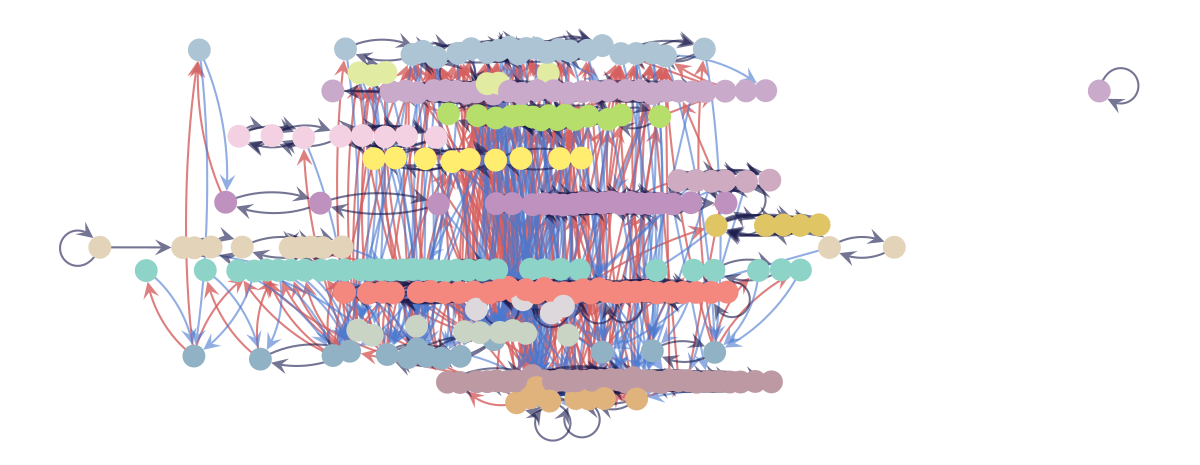

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff994413970, at 0x7ff7c71e88b0>

In [23]:
# Draw the ranked hierarchical block model
pos = sfdp_layout(graph, cooling_step=0.99, multilevel=False, R=50000,
                    rmap=r_state_dc.levels[0].get_vertex_order(),
                    )

# # Stretch the layout somewhat
# for v in graph.vertices():
#     pos[v][1] *= 40
#     pos[v][0] *= 20

ranked.levels[0].draw(pos=pos)


## Calculate enrichment of genes in each cluster in the network

In [24]:
from pprint import pprint
import json
import requests

In [25]:
go_names = pickle.load(open('../data/go_bio_process_2021_names.pickle','rb'))

In [26]:
len(go_names)

14937

# TODO figure out how to get names from blocks

In [27]:
hierarchical.print_summary()

l: 0, N: 271, B: 13
l: 1, N: 13, B: 4
l: 2, N: 4, B: 2
l: 3, N: 2, B: 1
l: 4, N: 1, B: 1


In [28]:
levels = hierarchical.get_levels()
for s in levels:
    print(s)
    if s.get_N() == 1:
        break

<BlockState object with 271 blocks (13 nonempty), degree-corrected, for graph <Graph object, directed, with 271 vertices and 878 edges, 2 internal vertex properties, at 0x7ff994413970>, at 0x7ff94165ceb0>
<BlockState object with 12 blocks (4 nonempty), for graph <Graph object, directed, with 271 vertices and 85 edges, 2 internal vertex properties, 1 internal edge property, at 0x7ff94165cdc0>, at 0x7ff94165c8e0>
<BlockState object with 5 blocks (2 nonempty), for graph <Graph object, directed, with 12 vertices and 16 edges, 2 internal vertex properties, 1 internal edge property, at 0x7ff94166a4f0>, at 0x7ff94165c370>
<BlockState object with 3 blocks (1 nonempty), for graph <Graph object, directed, with 5 vertices and 4 edges, 2 internal vertex properties, 1 internal edge property, at 0x7ff941672250>, at 0x7ff9a46a0250>
<BlockState object with 2 blocks (1 nonempty), for graph <Graph object, directed, with 3 vertices and 1 edge, 2 internal vertex properties, 1 internal edge property, at 0x

In [29]:
from collections import defaultdict

In [30]:
ids = defaultdict(list)
names = defaultdict(list)
for i,block in enumerate(hierarchical.get_levels()[0].b.a):
    ids[block].append(i)

c=0
for block, node_ids in ids.items():
    for node_id in node_ids:
        ensembl_id = graph.vertex_properties['id'][node_id]
        name_count = 0
        for name in protein_id_to_name[ensembl_id]:
            if name in go_names:
                names[block]+=[name]
                name_count+=1
            else:
                pass
                #print(f'unnamed {ensembl_id}')
        if name_count == 0:
            c+=1
#             print(ensembl_id, name_count)
print("Not in GO", c)
names = dict(names)

Not in GO 20


In [31]:
c=0
for id, block in names.items():
    print(len(block))
    c+=len(block)
print('-')
print(c)

17
20
18
31
30
19
8
13
23
24
27
14
7
-
251


In [32]:
def query_enrichr(names, gene_set_library):
    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
    genes_str = '\n'.join(names)
    description = 'Example gene list'
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')

    data = json.loads(response.text)
#     print(data)

    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    user_list_id = data['userListId']
    response = requests.get(
        ENRICHR_URL + query_string % (user_list_id, gene_set_library)
     )
    if not response.ok:
        raise Exception('Error fetching enrichment results')
    return json.loads(response.content)

In [33]:
def print_enrichment(response, gene_set_library, threshold=.01, pos_filter_words=None, neg_filter_words=None, n=None):
    if n is None:
        n = len(response[gene_set_library])
    
    for i,enr in enumerate(response[gene_set_library][:n]):
        pvalue = float(enr[6])
        term = enr[1]
        match=False
        if pvalue < threshold:
            if pos_filter_words:
                if any([word in term for word in pos_filter_words]):
                    match=True
            else:
                match=True
            if neg_filter_words:
                if any([word in term for word in neg_filter_words]):
                    match=False
            else:
                match=True
                    
        if match:
            for j in [1, 6]:
                print(headers[j], enr[j])
            print(', '.join(enr[5]))
            print('-')

In [34]:
gene_set_library = 'GO_Biological_Process_2021'

In [35]:
headers = ['Rank', 'Term name', 'P-value', 'Z-score', 'Combined score', 'Overlapping genes', 
           'Adjusted p-value', 'Old p-value', 'Old adjusted p-value']

In [36]:
responses = []
for block_id, block in names.items():
    response = query_enrichr(block, gene_set_library)
    responses.append((block_id, response))
    

In [37]:
positive_words = ['differentiation', 'development', 'signal', 'matrix', 'organization', 'proliferation', 'stem', 'pathway', 'morpho', 'mesoderm', 'endoderm', 'different', 'specification']
negative_words = ['transcription']

In [38]:
for block_id, response in responses:
    print("------------------------------------")
    print("BLOCK", block_id)
    print("------------------------------------")    
    print_enrichment(response, gene_set_library, pos_filter_words=positive_words, neg_filter_words=negative_words, n=10)

------------------------------------
BLOCK 41
------------------------------------
Term name regulation of protein kinase B signaling (GO:0051896)
Adjusted p-value 7.429580353825157e-10
PDGFRB, SLC9A3R1, KIT, PTEN, SPRY2, TEK, FGFR1, EPHA2
-
Term name regulation of phosphatidylinositol 3-kinase signaling (GO:0014066)
Adjusted p-value 4.352038087695748e-08
PDGFRB, SLC9A3R1, KIT, PTEN, TEK, FGFR1
-
Term name enzyme linked receptor protein signaling pathway (GO:0007167)
Adjusted p-value 1.0094068000619981e-07
PDGFRB, FLT4, KIT, TEK, FGFR1, EPHA2
-
Term name positive regulation of intracellular signal transduction (GO:1902533)
Adjusted p-value 3.30471619950686e-07
PDGFRB, SLC9A3R1, FLT4, KIT, SPRY2, S100A4, TEK, FGFR1
-
------------------------------------
BLOCK 61
------------------------------------
Term name Wnt signaling pathway (GO:0016055)
Adjusted p-value 1.1523178454035285e-09
WNT6, FZD5, WNT3A, WNT8A, WNT3, WLS, WNT4
-
Term name canonical Wnt signaling pathway (GO:0060070)
Adjuste

## Export enrichments as pickle

In [50]:
threshold = .01

enrichments = []
for response in responses:
    for enr in response[1][gene_set_library]:
        pvalue = float(enr[6])
        term = enr[1]
        genes = enr[5]
        enrichments.append((term, pvalue, genes))

pickle.dump(enrichments, open('../data/cluster_enrichments.pickle','wb'))

## Export nodes with cluster assignments

In [39]:
cluster_file = open('../data/connected_graph_nodes_clusters.csv', 'w')
cluster_file.write('Id,Label,HierarchicalCluster\n')
for block, node_ids in ids.items():
    for node_id in node_ids:
        ensembl_id = graph.vertex_properties['id'][node_id]
        cluster_file.write(','.join([ensembl_id, '/'.join(protein_id_to_name[ensembl_id]), str(block)]))
        cluster_file.write('\n')
cluster_file.close()